#  Back Testing an Enter-and-Exit Rule
---
In this exercise, I will be testing a strategy that identifies trends in prices.
The idea is to look at short-term and long-term trends in historical prices. Based on this, we are going to confer
the following rules:
- If the SMA (simple moving average) of the stock price over tha last M days is <mark>above</mark> the SMA of the last N days ($M<N$), then a <mark>long</mark> position should be established.
- If the SMA (simple moving average) of the stock price over tha last M days is <mark>below</mark> the SMA of the last N days ($M<N$), then a <mark>short</mark> position should be established.

With this in mind, the backtesting components of this strategy are the following:
1. Universe: 
    - Apple Stock
2. Signals:
    - Historical prices from July 2010 to July 2018 (daily closing prices)
    - SMA of past 42 days
    - SMA of past 252 days
3. Trading rules:
    - *Buy* if <span style='color:blue'>short SMA </span> > <span style='color:red'>long SMA </span>
    - *Sell* if <span style='color:blue'> short SMA </span> <= <span style='color:red'>long SMA </span>
4. Time lag:
    - We use next-day closing values to evaluate trading rules

In [4]:
## Importing relevat libraries
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
today = date.today()
print(today)

2020-08-09


In [5]:
# Company Ticker
symbol = "AAPL"

# Parameters for simple moving averages
SMA_s = 42
SMA_l = 252

#Import company stock data from yahoo finance
Company_data = yf.download(symbol,start = "2010-01-01",end=today, progress=True)

[*********************100%***********************]  1 of 1 completed


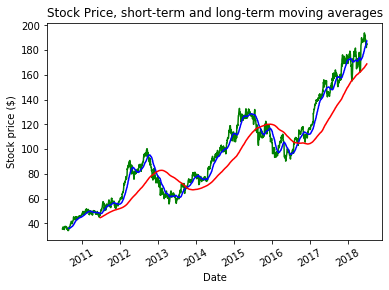

In [7]:
## Building data set and plotting signals over the sample period

# Clean company data
Company = Company_data.Close.to_frame()
Company.rename(columns={'Close': symbol},inplace = True)
Company.reset_index(inplace = True)
Company['Date'] = pd.to_datetime(Company.Date,format='%Y-%m-%d')
b_date = pd.to_datetime("2010-07-01",format='%Y-%m-%d') # beginning date
e_date = pd.to_datetime("2018-07-01",format='%Y-%m-%d') # ending date
data_analysis = Company.loc[(Company.Date>=b_date) & (Company.Date<=e_date),["Date",symbol]].copy()

# Calculate moving averages

data_analysis['SMA_s'] = data_analysis[symbol].rolling(SMA_s).mean() # compute simple-moving-average for short-term
data_analysis['SMA_l'] = data_analysis[symbol].rolling(SMA_l).mean() # compute simple-moving-average for long-term

# Plotting stock prices against short-term and long-term moving averages
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(data_analysis.Date, data_analysis[symbol], color='green')
plt.plot(data_analysis.Date, data_analysis['SMA_s'], color='blue')
plt.plot(data_analysis.Date, data_analysis['SMA_l'], color='red')
plt.title("Stock Price, short-term and long-term moving averages")
plt.ylabel("Stock price ($)")
plt.xlabel("Date")

ax.xaxis.set_tick_params(rotation=30, labelsize = 10)

## Creating trading rules

The next step is the construction of trading rules. For this, we are going to define <b>-1</b> as a short position, and <b>1</b> as a long position. This means that our rule is going to be:
- Take a long position (1) if <span style='color:blue'>short SMA </span> > <span style='color:red'>long SMA </span>
- Take a short position (-1)  if <span style='color:blue'>short SMA </span> <= <span style='color:red'>long SMA </span>


In [8]:
data_analysis.dropna(inplace = True) # keeping dates for which we have all signals
data_analysis['Position'] = np.where(data_analysis['SMA_s']>data_analysis['SMA_l'],1,-1)
data_analysis.head()

,Date,AAPL,SMA_s,SMA_l,Position
375,2011-06-29,47.720001,48.046258,44.748220,1
376,2011-06-30,47.952858,48.010170,44.797647,1
377,2011-07-01,49.037144,47.993367,44.852251,1
378,2011-07-05,49.918571,47.992891,44.909393,1
379,2011-07-06,50.251427,48.009932,44.962165,1


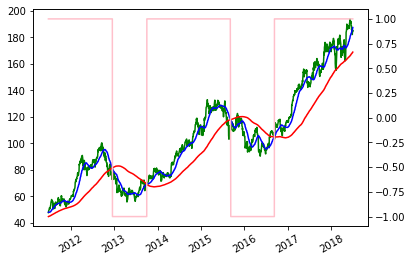

In [9]:
# Plot signals and position

fig, ax = plt.subplots()
plt.plot(data_analysis.Date,data_analysis[symbol],color="green")
plt.plot(data_analysis.Date,data_analysis['SMA_s'],color="blue")
plt.plot(data_analysis.Date,data_analysis['SMA_l'],color="red")
ax.xaxis.set_tick_params(rotation = 30, labelsize = 10)
ax2 = ax.twinx()
ax2.plot(data_analysis.Date,data_analysis.Position,color = 'Pink')

## Evaluating Performance

Now that we have created trade signals for our strategy, lets evaluate the performance of the strategy. 
Assume we invest $1000 in the strategy and compare it to buy and hold on the same stock. 

<b><u>Key Assumption:</b></u> Trading decision is based on the information from previous day to ensure we are not trading on future information.

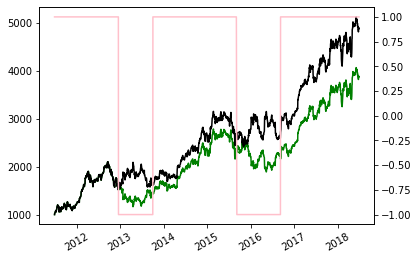

In [10]:
#Compute returns
lag_prc = data_analysis[symbol].shift(1) #Previous-day price
data_analysis['Ret_Stock'] = (data_analysis[symbol] - lag_prc)/lag_prc #compute daily return
data_analysis['Ret_Strat'] = data_analysis["Position"].shift(1) * data_analysis['Ret_Stock'] #Use previous-day position
#Compute $1000 invested in the two strategies
data_analysis.dropna(inplace=True)
initVal = 1000
cumValue_BHS = initVal*(1+data_analysis['Ret_Stock']).cumprod() #compute cumulative compounded returns of buy-and-hold strategy
cumValue_SMAS = initVal*(1+data_analysis['Ret_Strat']).cumprod() #compute cumulative compounded returns of SMAS strategy
fig, ax = plt.subplots()
plt.plot(data_analysis.Date, cumValue_BHS,color='green')
plt.plot(data_analysis.Date, cumValue_SMAS,color='black')
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()
ax2.plot(data_analysis.Date,data_analysis['Position'],color='pink')

In [11]:
#Compute arithmetic returns
avg_return = data_analysis[["Ret_Stock","Ret_Strat"]].mean()
volatility = data_analysis[["Ret_Stock","Ret_Strat"]].std()
#Annualized measures
annual_return = avg_return * 250
annual_vol = volatility * np.sqrt(250)
SR = annual_return/annual_vol #We assume for simplicity that the risk-free rate is zero, so excess returns equal raw returns
print("Investing $1000 in the buy-and-hold strategy produces $%5.1f over the investment period"%(cumValue_BHS.tail(1)))
print("Investing $1000 in the SMA strategy produces $%5.1f over the investment period"%(cumValue_SMAS.iloc[-1]))
# The instruction 'cumValue_SMAS.iloc[-1]' is equivalent to 'cumValue_SMAS.tail(1)
print("The annual arithmetic average return for BHS is %5.2f%% with a volatility of %5.2f%%"\
      %(annual_return[0]*100,annual_vol[0]*100))
print("The annual arithmetic average return for SMAS is %5.2f%% with a volatility of %5.2f%%"\
      %(annual_return[1]*100,annual_vol[1]*100))
print("The annualized Sharpe Ratio for the buy-and-hold strategy is %4.2f, for SMA is %4.2f" %(SR[0],SR[1]))

Investing $1000 in the buy-and-hold strategy produces $3879.1 over the investment period
Investing $1000 in the SMA strategy produces $4886.8 over the investment period
The annual arithmetic average return for BHS is 22.41% with a volatility of 25.15%
The annual arithmetic average return for SMAS is 25.67% with a volatility of 25.14%
The annualized Sharpe Ratio for the buy-and-hold strategy is 0.89, for SMA is 1.02


## Implication of Trading Costs

So far, we have only considered trade signals and how to execute trades based on them. In reality, transaction costs are also incurred which might change the return on the strategy.

Steps to calculate annual trading cost
<br>1) Calculate the average number of traders per years
<br>2) Multiply this by average trading cost

<u>Note:</u> When switching from to long to short, there are two costs associated with it since there are two transactions. 


** I use CIBC's Investor Edge and it costs me $6.95/trade

In [12]:
chg_pos = np.where(data_analysis["Position"].shift(1)==data_analysis["Position"],0,1) #mark trade positions (1 trade, 0 same position)
numTrades = chg_pos.sum() #count how many trades (ones) where observed across the sample
numYears = len(data_analysis)/250 #avg number of years in the sample: number of daily periods divided by number of days in a year
avg_numTrades = numTrades/numYears #average number of trades per year
trd_cost = 6.95/10000  #trading cost in basis points
tot_TrdCost = avg_numTrades*trd_cost*2 #Total trading cost per year
adj_ret = (annual_return[1]-tot_TrdCost) #annualized return adjsuted for trading costs
print("The average number of trades per year associated with the SMA strategy is %5.2f, representing an average annual cost of %5.2f bp"%(\
       avg_numTrades,tot_TrdCost*10000))
print("The adjusted return of the strategy is %5.2f%% (unadjusted is %5.2f%%)"%(adj_ret*100,annual_return[1]*100))

The average number of trades per year associated with the SMA strategy is  0.71, representing an average annual cost of  9.86 bp
The adjusted return of the strategy is 25.57% (unadjusted is 25.67%)
